<a href="https://colab.research.google.com/github/jai2shan/TSAI_END2/blob/main/Session%203/Session_3_Pytorch%2097.71%20Accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Session 3  - Assignment


---
Digit Recognizer     
---
Train Accuracy : 98.84%     
Test Accuracy  : 99.07%  


---
Sum Calculator Model    
---
Train Accuracy : 94.47%     
Test Accuracy  : 97.26%     
 

---

## Data Downloading


Downloading data to colab environment using Pytorch




In [20]:
from torchvision import datasets
datasets.MNIST('data', download=True)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train

## Importing the necessary modules

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm

## Custom Data Loader

1. Loaded the downloaded data from the colab environment using torch.load method
2. In the "__getitem__" method,
          1) Loaded the data
          2) Created randomm integer
          3) Made a tuple with the expected target variables and input variables

In [22]:
class CustomLoader_MNIST(DataLoader):
    def __init__(self,pt_path):
        self.path = pt_path
        self.data = torch.load(self.path)
        

    def __getitem__(self, idx):
      if torch.is_tensor(idx):
        idx = idx.tolist()

      image, label = self.data[0][idx], self.data[1][idx] 

      randInt = torch.randint(0,9,(1,))
      x1, x2, y1, y2 = image.reshape(1,28,28), randInt, label, label + randInt[0]

      return x1, x2, y1, y2

    def __len__(self):
      return len(self.data[0])

train_data = CustomLoader_MNIST("/content/data/MNIST/processed/training.pt")
test_data = CustomLoader_MNIST("/content/data/MNIST/processed/test.pt")

## Load the data and check of GPU is available for training the model

In [23]:
torch.manual_seed(1)
batch_size = 1024
use_cuda = torch.cuda.is_available()

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, **kwargs)

# Network Architecture
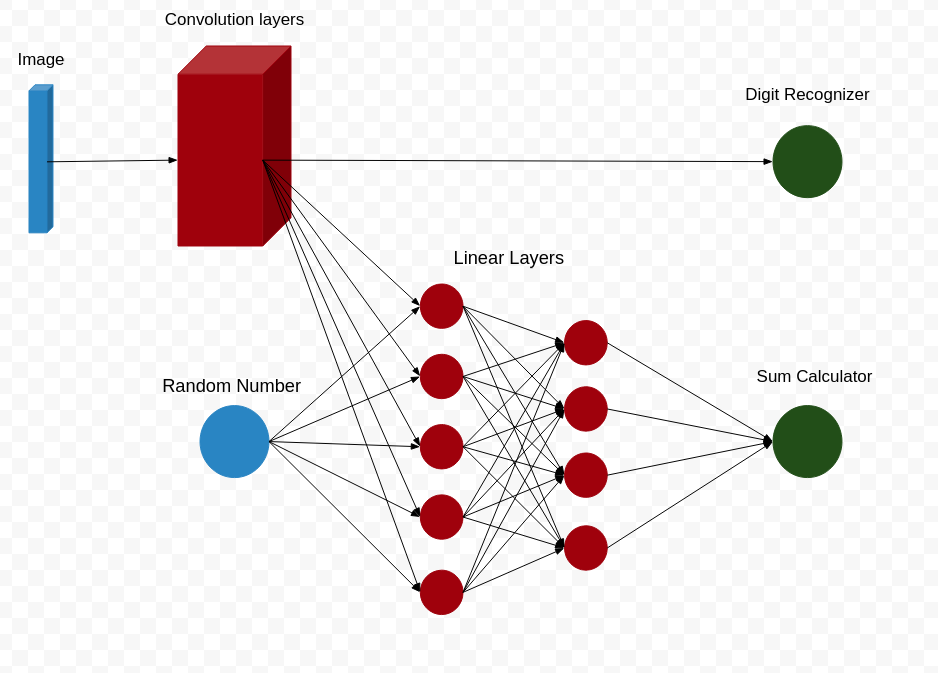

In [24]:

dropout_value = 0.1

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 

        self.dropout = nn.Dropout(dropout_value)
        self.relu = nn.ReLU()
        self.ln1 = nn.Linear(11,30)
        self.ln2 = nn.Linear(30,19)

    def forward(self, img, rnum):        
        img = self.convblock1(img)
        img = self.convblock2(img)
        img = self.convblock3(img)
        img = self.pool1(img)
        img = self.convblock4(img)
        img = self.convblock5(img)
        img = self.convblock6(img)
        img = self.convblock7(img)
        img = self.gap(img)        
        img = self.convblock8(img)
        img = img.view(-1, 10)

        rnum = torch.cat((img, rnum), dim=1)
        rnum = self.ln1(rnum)
        rnum = self.relu(rnum)
        rnum = self.ln2(rnum)

        img = F.log_softmax(img, dim=-1)
        rnum = F.log_softmax(rnum, dim=-1)
        return img, rnum

## Enable cuda for calculation
1. Check if GPU is available for computation
2. if available move the model to GPU

In [25]:

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)

cuda


## Train and Test Functions

Model will be trained by following below steps:
1. Move the below variables to GPU       
    a) x1 - Image      
    b) x2 - Random Number     
    c) y1 - image output     
    d) y2 - Sum of digit in the image and random number     
2. Calculate loss using the Negative loglikelihood function for both digit recognizing and sum calculation
3. Calculate total loss by adding both the values. To improve model accuracy, loss2(Sum calculation network loss) is multiplied by 2 in order to increase its weightage in loss so that the overall loss is magnified for every one unit of loss in Sum calculation network 
4. Plot function will help us visualize improve of accuracy with various epochs





In [26]:
def train(model, device, train_loader, optimizer, epoch):

  model.train()
  pbar = tqdm(train_loader)
  correct1 = 0
  processed = 0
  correct2 = 0

  for batch_idx, (x1, x2, y1, y2) in enumerate(pbar):
    # Data
    x1, x2, y1, y2 = x1.float().to(device), x2.float().to(device), y1.to(device), y2.to(device)
    # Init
    
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict

    y1_pred, y2_pred = model(x1, x2)

    # Calculate loss
    loss1 = F.nll_loss(y1_pred, y1)
    loss2 = F.nll_loss(y2_pred, y2)

    # Cross Entropy Loss
    # loss1 = loss1_(y1_pred, y1)
    # loss2 = loss2_(y2_pred, y2)

    loss =  torch.add(loss1, loss2*2)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()


    
    pred1 = y1_pred.argmax(dim=1, keepdim=True)
    pred2 = y2_pred.argmax(dim=1, keepdim=True)
    
    # get the index of the max log-probability
    correct1 += pred1.eq(y1.view_as(pred1)).sum().item()
    correct2 += pred2.eq(y2.view_as(pred2)).sum().item()
    processed += len(x1)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy_digit={100*correct1/processed:0.2f} Accuracy_Rnum={100*correct2/processed:0.2f}')
    train_acc['Image'].append(100*correct1/processed)
    train_acc['RandomNumber'].append(100*correct2/processed)

def test(model, device, test_loader):
    model.eval()
    correct1 = 0
    correct2 = 0
    with torch.no_grad():
        for x1, x2, y1, y2 in test_loader:
            x1, x2, y1, y2 = x1.float().to(device), x2.float().to(device), y1.to(device), y2.to(device)
            y1_pred, y2_pred = model(x1, x2)
            
            pred1 = y1_pred.argmax(dim=1, keepdim=True)
            pred2 = y2_pred.argmax(dim=1, keepdim=True)
            correct1 += pred1.eq(y1.view_as(pred1)).sum().item()
            correct2 += pred2.eq(y2.view_as(pred2)).sum().item()

    print('Test set: Accuracy_digit={} Accuracy_Rnum={}'.format(100*correct1/len(test_loader.dataset),100*correct2/len(test_loader.dataset)))
    test_acc['Image'].append(100*correct1/len(test_loader.dataset))
    test_acc['RandomNumber'].append(100*correct2/len(test_loader.dataset))



def plot_performance(train_acc, test_acc):
  fig, axs = plt.subplots(2,2,figsize=(15,10))

  axs[0, 0].plot(train_acc['Image'])
  axs[0, 0].set_title("Training - Image")
  axs[0, 1].plot(train_acc['RandomNumber'])
  axs[0, 1].set_title("Training - Random Number Model")
  axs[1, 0].plot(test_acc['Image'])
  axs[1, 0].set_title("Test - Image")
  axs[1, 1].plot(test_acc['RandomNumber'])
  axs[1, 1].set_title("Test - Random Number Model")

## Defining Optimiser and Training the model

  0%|          | 0/59 [00:00<?, ?it/s]

EPOCH: 0


Loss=6.5907440185546875 Batch_id=58 Accuracy_digit=43.80 Accuracy_Rnum=10.10: 100%|██████████| 59/59 [00:02<00:00, 26.10it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=64.13 Accuracy_Rnum=13.56
EPOCH: 1


Loss=4.7635650634765625 Batch_id=58 Accuracy_digit=75.89 Accuracy_Rnum=17.05: 100%|██████████| 59/59 [00:02<00:00, 27.46it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=88.26 Accuracy_Rnum=21.47
EPOCH: 2


Loss=3.6664390563964844 Batch_id=58 Accuracy_digit=91.58 Accuracy_Rnum=30.13: 100%|██████████| 59/59 [00:02<00:00, 26.54it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=94.04 Accuracy_Rnum=36.51
EPOCH: 3


Loss=3.091290235519409 Batch_id=58 Accuracy_digit=94.66 Accuracy_Rnum=42.44: 100%|██████████| 59/59 [00:02<00:00, 25.95it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=96.2 Accuracy_Rnum=46.52
EPOCH: 4


Loss=2.639270067214966 Batch_id=58 Accuracy_digit=96.05 Accuracy_Rnum=50.85: 100%|██████████| 59/59 [00:02<00:00, 26.14it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=97.18 Accuracy_Rnum=58.52
EPOCH: 5


Loss=2.429792881011963 Batch_id=58 Accuracy_digit=96.48 Accuracy_Rnum=57.12: 100%|██████████| 59/59 [00:02<00:00, 26.10it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=97.52 Accuracy_Rnum=59.22
EPOCH: 6


Loss=2.2152998447418213 Batch_id=58 Accuracy_digit=97.00 Accuracy_Rnum=63.11: 100%|██████████| 59/59 [00:02<00:00, 25.83it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.12 Accuracy_Rnum=65.98
EPOCH: 7


Loss=2.145993232727051 Batch_id=58 Accuracy_digit=97.24 Accuracy_Rnum=66.56: 100%|██████████| 59/59 [00:02<00:00, 25.78it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.19 Accuracy_Rnum=65.91
EPOCH: 8


Loss=2.0150792598724365 Batch_id=58 Accuracy_digit=97.38 Accuracy_Rnum=69.64: 100%|██████████| 59/59 [00:02<00:00, 25.37it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=97.85 Accuracy_Rnum=67.9
EPOCH: 9


Loss=1.9284826517105103 Batch_id=58 Accuracy_digit=97.49 Accuracy_Rnum=73.06: 100%|██████████| 59/59 [00:02<00:00, 26.03it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.17 Accuracy_Rnum=82.38
EPOCH: 10


Loss=1.5579249858856201 Batch_id=58 Accuracy_digit=97.57 Accuracy_Rnum=75.01: 100%|██████████| 59/59 [00:02<00:00, 26.28it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.12 Accuracy_Rnum=76.93
EPOCH: 11


Loss=1.5654081106185913 Batch_id=58 Accuracy_digit=97.71 Accuracy_Rnum=76.24: 100%|██████████| 59/59 [00:02<00:00, 26.25it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.4 Accuracy_Rnum=81.31
EPOCH: 12


Loss=1.5668195486068726 Batch_id=58 Accuracy_digit=97.77 Accuracy_Rnum=77.98: 100%|██████████| 59/59 [00:02<00:00, 25.68it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.29 Accuracy_Rnum=82.02
EPOCH: 13


Loss=1.5210175514221191 Batch_id=58 Accuracy_digit=97.95 Accuracy_Rnum=79.87: 100%|██████████| 59/59 [00:02<00:00, 26.65it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.65 Accuracy_Rnum=80.07
EPOCH: 14


Loss=1.3755251169204712 Batch_id=58 Accuracy_digit=97.99 Accuracy_Rnum=80.42: 100%|██████████| 59/59 [00:02<00:00, 25.95it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.52 Accuracy_Rnum=82.51
EPOCH: 15


Loss=1.3584563732147217 Batch_id=58 Accuracy_digit=98.00 Accuracy_Rnum=82.16: 100%|██████████| 59/59 [00:02<00:00, 26.67it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.77 Accuracy_Rnum=84.51
EPOCH: 16


Loss=1.1608330011367798 Batch_id=58 Accuracy_digit=98.17 Accuracy_Rnum=83.38: 100%|██████████| 59/59 [00:02<00:00, 27.07it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.56 Accuracy_Rnum=86.68
EPOCH: 17


Loss=1.2385852336883545 Batch_id=58 Accuracy_digit=98.14 Accuracy_Rnum=82.59: 100%|██████████| 59/59 [00:02<00:00, 25.91it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.86 Accuracy_Rnum=89.72
EPOCH: 18


Loss=1.1152284145355225 Batch_id=58 Accuracy_digit=98.19 Accuracy_Rnum=85.13: 100%|██████████| 59/59 [00:02<00:00, 25.72it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.74 Accuracy_Rnum=88.33
EPOCH: 19


Loss=1.1259714365005493 Batch_id=58 Accuracy_digit=98.18 Accuracy_Rnum=85.34: 100%|██████████| 59/59 [00:02<00:00, 25.43it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.5 Accuracy_Rnum=89.74
EPOCH: 20


Loss=1.0117626190185547 Batch_id=58 Accuracy_digit=98.27 Accuracy_Rnum=86.61: 100%|██████████| 59/59 [00:02<00:00, 25.92it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.8 Accuracy_Rnum=86.67
EPOCH: 21


Loss=1.1465823650360107 Batch_id=58 Accuracy_digit=98.31 Accuracy_Rnum=85.77: 100%|██████████| 59/59 [00:02<00:00, 25.73it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.65 Accuracy_Rnum=91.14
EPOCH: 22


Loss=0.923012375831604 Batch_id=58 Accuracy_digit=98.30 Accuracy_Rnum=88.05: 100%|██████████| 59/59 [00:02<00:00, 25.94it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.75 Accuracy_Rnum=92.07
EPOCH: 23


Loss=0.8338773250579834 Batch_id=58 Accuracy_digit=98.33 Accuracy_Rnum=88.35: 100%|██████████| 59/59 [00:02<00:00, 25.68it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.64 Accuracy_Rnum=92.14
EPOCH: 24


Loss=0.9446979761123657 Batch_id=58 Accuracy_digit=98.39 Accuracy_Rnum=89.43: 100%|██████████| 59/59 [00:02<00:00, 25.94it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.8 Accuracy_Rnum=89.84
EPOCH: 25


Loss=0.806269645690918 Batch_id=58 Accuracy_digit=98.44 Accuracy_Rnum=89.37: 100%|██████████| 59/59 [00:02<00:00, 25.84it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.95 Accuracy_Rnum=93.12
EPOCH: 26


Loss=0.9183427691459656 Batch_id=58 Accuracy_digit=98.38 Accuracy_Rnum=89.36: 100%|██████████| 59/59 [00:02<00:00, 25.81it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.92 Accuracy_Rnum=92.23
EPOCH: 27


Loss=0.7620542645454407 Batch_id=58 Accuracy_digit=98.40 Accuracy_Rnum=88.38: 100%|██████████| 59/59 [00:02<00:00, 25.75it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.72 Accuracy_Rnum=91.01
EPOCH: 28


Loss=0.8737534284591675 Batch_id=58 Accuracy_digit=98.56 Accuracy_Rnum=90.33: 100%|██████████| 59/59 [00:02<00:00, 25.78it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.8 Accuracy_Rnum=92.48
EPOCH: 29


Loss=0.7985302209854126 Batch_id=58 Accuracy_digit=98.46 Accuracy_Rnum=89.99: 100%|██████████| 59/59 [00:02<00:00, 26.32it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.82 Accuracy_Rnum=93.76
EPOCH: 30


Loss=0.9607827663421631 Batch_id=58 Accuracy_digit=98.48 Accuracy_Rnum=90.75: 100%|██████████| 59/59 [00:02<00:00, 27.24it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.81 Accuracy_Rnum=93.31
EPOCH: 31


Loss=0.9402143359184265 Batch_id=58 Accuracy_digit=98.50 Accuracy_Rnum=90.47: 100%|██████████| 59/59 [00:02<00:00, 26.12it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.51 Accuracy_Rnum=91.65
EPOCH: 32


Loss=0.6297791004180908 Batch_id=58 Accuracy_digit=98.53 Accuracy_Rnum=89.34: 100%|██████████| 59/59 [00:02<00:00, 25.67it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.93 Accuracy_Rnum=95.0
EPOCH: 33


Loss=0.602292001247406 Batch_id=58 Accuracy_digit=98.61 Accuracy_Rnum=92.31: 100%|██████████| 59/59 [00:02<00:00, 25.55it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.98 Accuracy_Rnum=92.38
EPOCH: 34


Loss=0.6954554915428162 Batch_id=58 Accuracy_digit=98.66 Accuracy_Rnum=91.59: 100%|██████████| 59/59 [00:02<00:00, 25.74it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.02 Accuracy_Rnum=93.7
EPOCH: 35


Loss=0.8441332578659058 Batch_id=58 Accuracy_digit=98.65 Accuracy_Rnum=92.10: 100%|██████████| 59/59 [00:02<00:00, 25.98it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.88 Accuracy_Rnum=94.92
EPOCH: 36


Loss=0.6024122834205627 Batch_id=58 Accuracy_digit=98.68 Accuracy_Rnum=92.54: 100%|██████████| 59/59 [00:02<00:00, 25.45it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.99 Accuracy_Rnum=93.42
EPOCH: 37


Loss=0.586248517036438 Batch_id=58 Accuracy_digit=98.67 Accuracy_Rnum=92.14: 100%|██████████| 59/59 [00:02<00:00, 25.78it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.97 Accuracy_Rnum=94.69
EPOCH: 38


Loss=0.5468176007270813 Batch_id=58 Accuracy_digit=98.73 Accuracy_Rnum=92.47: 100%|██████████| 59/59 [00:02<00:00, 25.72it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.92 Accuracy_Rnum=96.8
EPOCH: 39


Loss=0.8474252223968506 Batch_id=58 Accuracy_digit=98.66 Accuracy_Rnum=92.60: 100%|██████████| 59/59 [00:02<00:00, 25.53it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.88 Accuracy_Rnum=93.77
EPOCH: 40


Loss=0.6102377772331238 Batch_id=58 Accuracy_digit=98.69 Accuracy_Rnum=93.02: 100%|██████████| 59/59 [00:02<00:00, 25.78it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.02 Accuracy_Rnum=95.77
EPOCH: 41


Loss=0.5655516982078552 Batch_id=58 Accuracy_digit=98.74 Accuracy_Rnum=93.45: 100%|██████████| 59/59 [00:02<00:00, 25.64it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.01 Accuracy_Rnum=96.99
EPOCH: 42


Loss=0.4847729206085205 Batch_id=58 Accuracy_digit=98.77 Accuracy_Rnum=94.02: 100%|██████████| 59/59 [00:02<00:00, 25.92it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.04 Accuracy_Rnum=96.6
EPOCH: 43


Loss=0.6949523687362671 Batch_id=58 Accuracy_digit=98.73 Accuracy_Rnum=93.40: 100%|██████████| 59/59 [00:02<00:00, 26.04it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.01 Accuracy_Rnum=96.56
EPOCH: 44


Loss=0.7122572064399719 Batch_id=58 Accuracy_digit=98.80 Accuracy_Rnum=94.67: 100%|██████████| 59/59 [00:02<00:00, 26.89it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.91 Accuracy_Rnum=96.6
EPOCH: 45


Loss=0.4315113127231598 Batch_id=58 Accuracy_digit=98.79 Accuracy_Rnum=94.36: 100%|██████████| 59/59 [00:02<00:00, 26.20it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.04 Accuracy_Rnum=96.56
EPOCH: 46


Loss=0.4657336175441742 Batch_id=58 Accuracy_digit=98.77 Accuracy_Rnum=94.31: 100%|██████████| 59/59 [00:02<00:00, 25.56it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.06 Accuracy_Rnum=97.2
EPOCH: 47


Loss=0.7397429943084717 Batch_id=58 Accuracy_digit=98.83 Accuracy_Rnum=94.84: 100%|██████████| 59/59 [00:02<00:00, 25.24it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.83 Accuracy_Rnum=96.73
EPOCH: 48


Loss=0.43895888328552246 Batch_id=58 Accuracy_digit=98.79 Accuracy_Rnum=94.87: 100%|██████████| 59/59 [00:02<00:00, 25.31it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.07 Accuracy_Rnum=94.97
EPOCH: 49


Loss=0.6774522662162781 Batch_id=58 Accuracy_digit=98.91 Accuracy_Rnum=95.01: 100%|██████████| 59/59 [00:02<00:00, 25.35it/s]


Test set: Accuracy_digit=99.07 Accuracy_Rnum=97.71


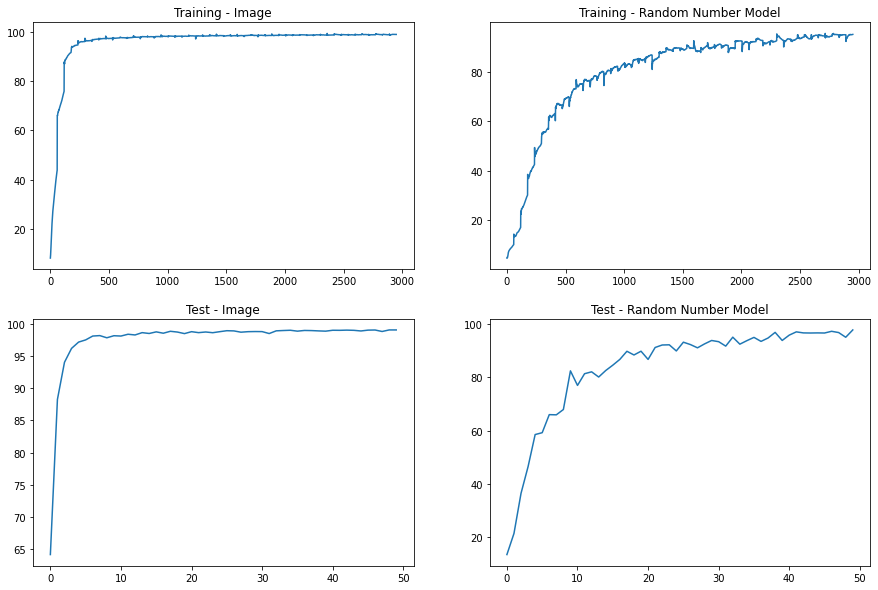

In [27]:
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim

train_losses = []
test_losses =  []
train_acc =  {'Image': [], 'RandomNumber': []}
test_acc = {'Image': [], 'RandomNumber': []}

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9)

EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

plot_performance(train_acc, test_acc)